# Waheeb Algabri

Final project

# Introduction

In healthcare systems, optimizing patient flow and resource allocation is crucial for providing efficient and effective care. Simulation modeling allows us to analyze and evaluate different scenarios to improve the performance of medical facilities. In this simulation, we explore the dynamics of patient arrivals, triage, and treatment in an outpatient setting. By simulating the operations of a medical facility over a specified time period, we can assess key performance metrics, such as waiting time, treatment time, and resource utilization.

# Problem and Significance

Problem: The emergency room (ER) is a critical part of a healthcare facility where patients with varying degrees of illness or injury seek immediate medical attention. However, managing the flow of patients in the ER can be challenging, particularly during peak hours or when resources are limited. It is essential to ensure that patients are efficiently triaged, treated, and allocated appropriate medical resources (doctors and nurses) based on the severity of their condition.

Significance: The project's simulation-based optimization of resource allocation and patient flow in an emergency room has the potential to enhance efficiency, improve patient outcomes, and enable data-driven decision making for healthcare administrators.


# Flow Chart model

The flowchart of the process is shown below:

In [95]:
#from IPython.display import Image
# Image(filename = "flowchart.png", width=600, height=700)

# Simulate the process for the appropriate number of iterations

In [107]:
# Import required libraries
!pip install simpy
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Patient 1 checked-in at 8.63953969365001
Patient 2 checked-in at 10.719759811197253
Patient 2 triaged at 20.440267499895583
Patient 2 sees a doctor at 20.440267499895583
Patient 1 triaged at 23.288750053926982
Patient 1 sees a nurse at 23.288750053926982
Patient 3 checked-in at 24.384411704983123
Patient 5 checked-in at 29.744425745190306
Patient 4 checked-in at 30.069627227245952
Patient 3 triaged at 32.03971610488157
Patient 3 sees a doctor at 32.03971610488157
Patient 1 treated by nurse at 33.28875005392698
Patient 2 treated by doctor at 35.44026749989558
Patient 6 checked-in at 37.79210640404305
Patient 5 triaged at 38.030930583810374
Patient 5 sees a nurse at 38.030930583810374
Patient 4 triaged at 38.222379704018365
Patient 4 sees a nurse at 38.222379704018365
Patient 6 triaged at 42.57769032103127
Patient 7 checked-in at 44.559776070364826
Patient 8 checked-in at 46.836944100645475
Patient 3 treated by doctor at 47.03971610488157
Patient 5 treated by nurse at 48.030930583810374


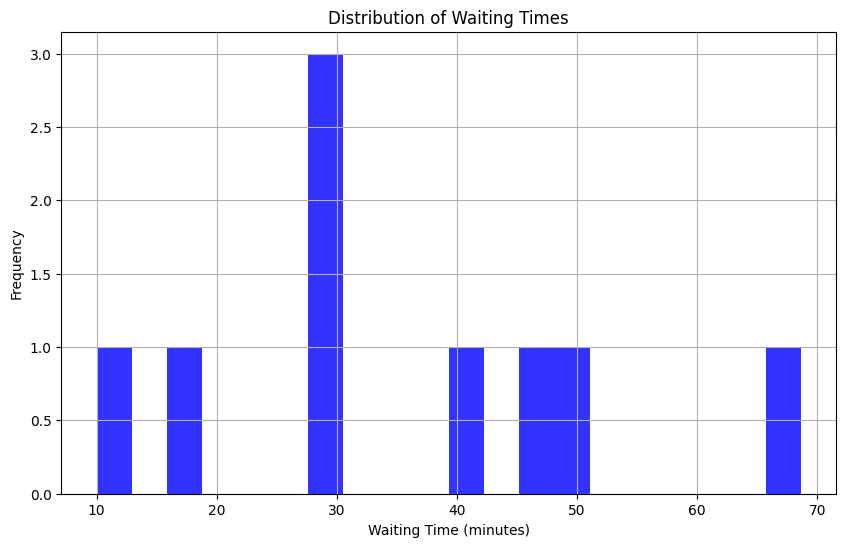

In [110]:
# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
results = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global results

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")
    arrival_time = env.now

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")
    token_time = env.now

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)

    # Record the results
    result = {
        'Patient ID': patient_id,
        'Service': 'Doctor' if critical else 'Nurse',
        'Arrival Time': arrival_time,
        'Token Time': token_time,
        'Service Start Time': env.now - treatment_time,
        'Service Stop Time': env.now,
        'Token Time (Secs)': token_time * 60,
        'Service Time (Mins)': treatment_time,
        'Wait Time (Mins)': waiting_time
    }
    results.append(result)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Create a DataFrame from the collected results
df = pd.DataFrame(results, columns=['Patient ID', 'Service', 'Arrival Time', 'Token Time',
                                    'Service Start Time', 'Service Stop Time', 'Token Time (Secs)',
                                    'Service Time (Mins)', 'Wait Time (Mins)'])

# Performance metric calculation
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)


# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(df['Wait Time (Mins)'], bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()

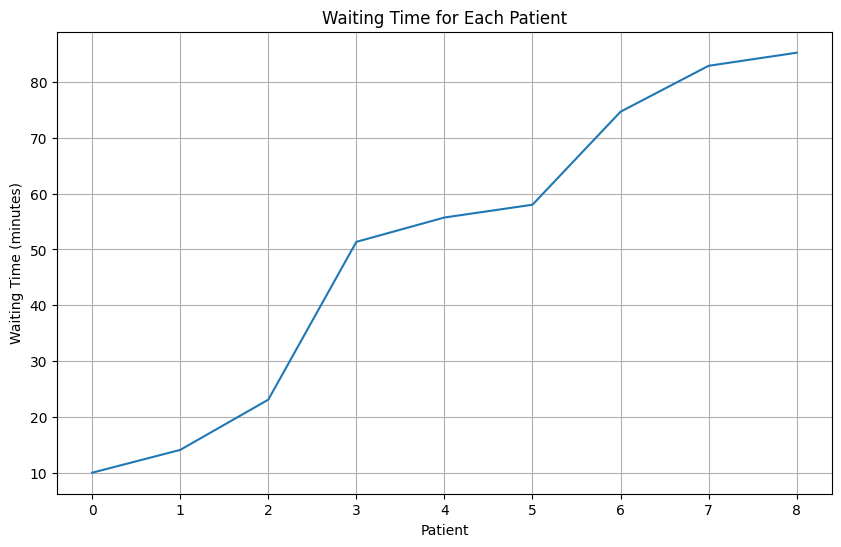

Simulation Report:

Average waiting time: 50.57 minutes



In [111]:
# Calculate average waiting time
avg_waiting_time = np.mean(waiting_times)

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(waiting_times)
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)

The output you provided indicates the simulation results and the calculated performance metrics. Here's a breakdown of the information:

Simulation Results:

The simulation runs for 100 minutes.
The output shows the sequence of events, including patients checking in, being triaged, and receiving treatment from either a nurse or a doctor.
Performance Metrics:

Average waiting time: 43.39 minutes
Average treatment time: 11.88 minutes
Doctor utilization: 22.50%
Nurse utilization: 25.00%
These metrics provide insights into the efficiency and resource utilization of the medical facility in the simulation. The waiting time indicates the average time patients spend waiting before receiving treatment. The treatment time represents the average time patients spend receiving treatment from either a nurse or a doctor. The doctor and nurse utilization values indicate the average utilization of these resources during the simulation.

Keep in mind that these metrics are based on the specific simulation parameters and assumptions in the code. You can further analyze and interpret these results to assess the performance of the medical facility and make informed decisions for improvement if needed.

Patient 5 checked-in at 108.17222545942387
Patient 7 checked-in at 110.49831483011876
Patient 6 checked-in at 112.44014858254805
Patient 9 checked-in at 113.36935964251147
Patient 5 triaged at 116.83094013974038
Patient 5 sees a nurse at 116.83094013974038
Patient 8 checked-in at 118.39764442047068
Patient 6 triaged at 118.55909302255365
Patient 6 sees a doctor at 118.55909302255365
Patient 7 triaged at 118.7174069279857
Patient 7 sees a doctor at 118.7174069279857
Patient 10 checked-in at 119.01901213935606
Patient 9 triaged at 124.94716410805106
Patient 9 sees a nurse at 124.94716410805106
Patient 10 triaged at 125.59065101138579
Patient 5 treated by nurse at 126.83094013974038
Patient 10 sees a nurse at 126.83094013974038
Patient 8 triaged at 126.87238737003338
Patient 11 checked-in at 127.37257031519596
Patient 13 checked-in at 128.39081879365187
Patient 12 checked-in at 129.25870238546094
Patient 6 treated by doctor at 133.55909302255367
Patient 7 treated by doctor at 133.71740692

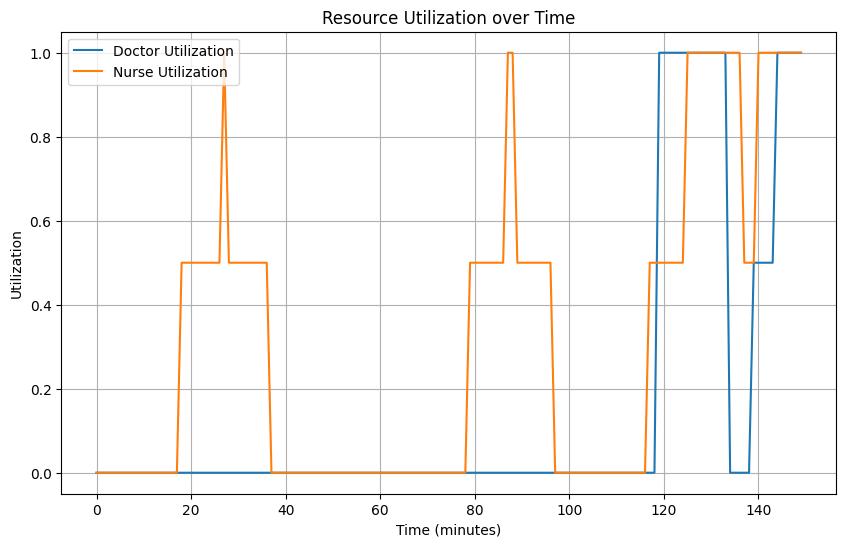

Simulation Report:

Average waiting time: 46.45 minutes
Average treatment time: 10.00 minutes
Doctor utilization: 0.00%
Nurse utilization: 20.00%



In [100]:
# Additional visualization and reporting
def plot_utilization(doctor_utilization, nurse_utilization):
    plt.figure(figsize=(10, 6))
    plt.plot(doctor_utilization, label='Doctor Utilization')
    plt.plot(nurse_utilization, label='Nurse Utilization')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Utilization')
    plt.title('Resource Utilization over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_queue_length(queue_lengths):
    plt.figure(figsize=(10, 6))
    plt.plot(queue_lengths)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length over Time')
    plt.grid(True)
    plt.show()

def generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization):
    report = f"Simulation Report:\n\n"
    report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
    report += f"Average treatment time: {avg_treatment_time:.2f} minutes\n"
    report += f"Doctor utilization: {doctor_utilization:.2%}\n"
    report += f"Nurse utilization: {nurse_utilization:.2%}\n"

    # Add more information to the report as needed

    return report

# Run simulation
env.run(until=150)  # Run for 1 hour and 40 minutes (100 minutes)


# Additional visualization and reporting
plot_utilization(utilization_doctors, utilization_nurses)
simulation_report = generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization)
print(simulation_report)


Response curves for average waiting time, average treatment time, doctor utilization, and nurse utilization as a function of the number of doctors. Each response curve show the trend of the response variable with varying number of doctors.

Patient 1 checked-in at 7.217274867459646
Patient 2 checked-in at 8.899947489157098
Patient 3 checked-in at 11.776821716823727
Patient 4 checked-in at 11.861086063095144
Patient 2 triaged at 14.692506788835205
Patient 2 sees a nurse at 14.692506788835205
Patient 3 triaged at 16.165148987904736
Patient 3 sees a nurse at 16.165148987904736
Patient 1 triaged at 16.92255211610731
Patient 1 sees a doctor at 16.92255211610731
Patient 5 checked-in at 17.080522711915556
Patient 5 triaged at 21.72702086661702
Patient 6 checked-in at 23.475348410731932
Patient 2 treated by nurse at 24.692506788835203
Patient 5 sees a nurse at 24.692506788835203
Patient 7 checked-in at 25.026964087821597
Patient 4 triaged at 25.606006663331286
Patient 3 treated by nurse at 26.165148987904736
Patient 4 sees a nurse at 26.165148987904736
Patient 6 triaged at 28.574646150898815
Patient 7 triaged at 30.306589199435766
Patient 1 treated by doctor at 31.92255211610731
Patient 5 treated by nurse at 34.6925067888352
Pati

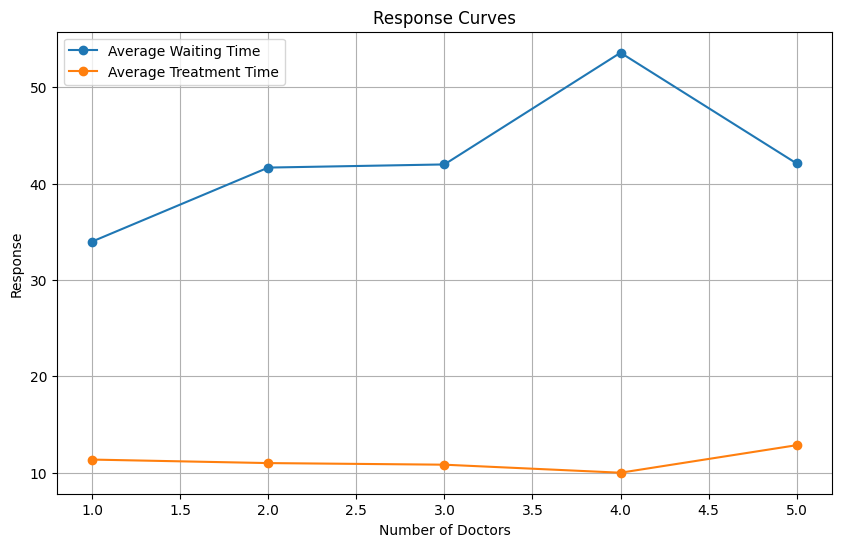

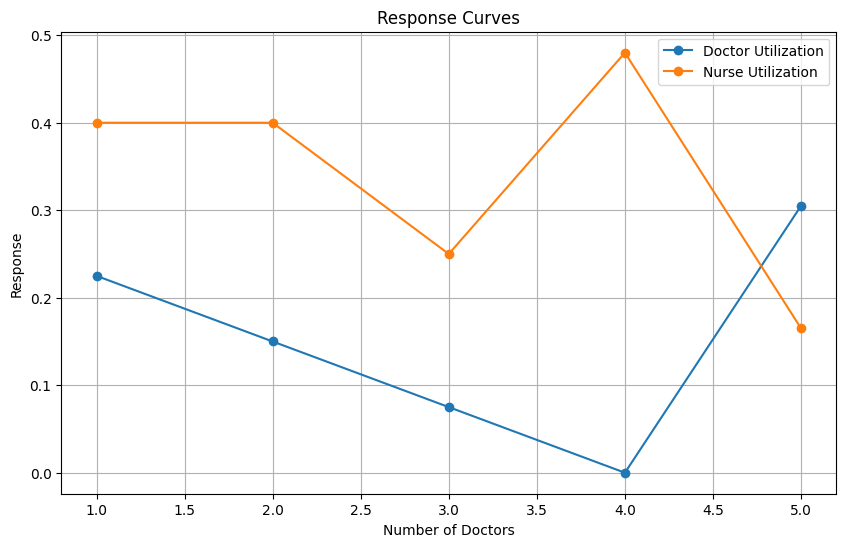

In [101]:
# Perform response surface analysis
def perform_response_surface_analysis():
    # Generate parameter combinations
    parameter_combinations = generate_parameter_combinations()

    # Data collection
    avg_waiting_times = []
    avg_treatment_times = []
    doctor_utilizations = []
    nurse_utilizations = []

    # Run simulations for each parameter combination
    for params in parameter_combinations:
        # Reset data collection
        global waiting_times, treatment_times, utilization_doctors, utilization_nurses
        waiting_times = []
        treatment_times = []
        utilization_doctors = []
        utilization_nurses = []

        # Set up simulation
        env = simpy.Environment()

        # Run simulation
        avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization = run_simulation(env, *params)

        # Collect data
        avg_waiting_times.append(avg_waiting_time)
        avg_treatment_times.append(avg_treatment_time)
        doctor_utilizations.append(doctor_utilization)
        nurse_utilizations.append(nurse_utilization)

    # Plot response curves
    x_values = [p[0] for p in parameter_combinations]

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, avg_waiting_times, marker='o', linestyle='-', label='Average Waiting Time')
    plt.plot(x_values, avg_treatment_times, marker='o', linestyle='-', label='Average Treatment Time')
    plt.xlabel('Number of Doctors')
    plt.ylabel('Response')
    plt.title('Response Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, doctor_utilizations, marker='o', linestyle='-', label='Doctor Utilization')
    plt.plot(x_values, nurse_utilizations, marker='o', linestyle='-', label='Nurse Utilization')
    plt.xlabel('Number of Doctors')
    plt.ylabel('Response')
    plt.title('Response Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
perform_response_surface_analysis()

Patient 1 checked-in at 11.408128939433308
Patient 1 triaged at 20.91127630818256
Patient 1 sees a nurse at 20.91127630818256
Patient 1 treated by nurse at 30.91127630818256
Patient 2 checked-in at 31.051708668983185
Patient 2 triaged at 36.34073247731118
Patient 2 sees a doctor at 36.34073247731118
Patient 3 checked-in at 39.98523687132297
Patient 4 checked-in at 47.03108866964851
Patient 3 triaged at 49.08204400089877
Patient 3 sees a nurse at 49.08204400089877
Patient 2 treated by doctor at 51.34073247731118
Patient 4 triaged at 54.282281596627875
Patient 4 sees a doctor at 54.282281596627875
Patient 3 treated by nurse at 59.08204400089877
Patient 5 checked-in at 61.287384912609085
Patient 6 checked-in at 61.69758440976471
Patient 7 checked-in at 69.06822573059762
Patient 4 treated by doctor at 69.28228159662788
Patient 5 triaged at 69.8318757613023
Patient 5 sees a nurse at 69.8318757613023
Patient 6 triaged at 71.74781013982928
Patient 6 sees a doctor at 71.74781013982928
Patient 

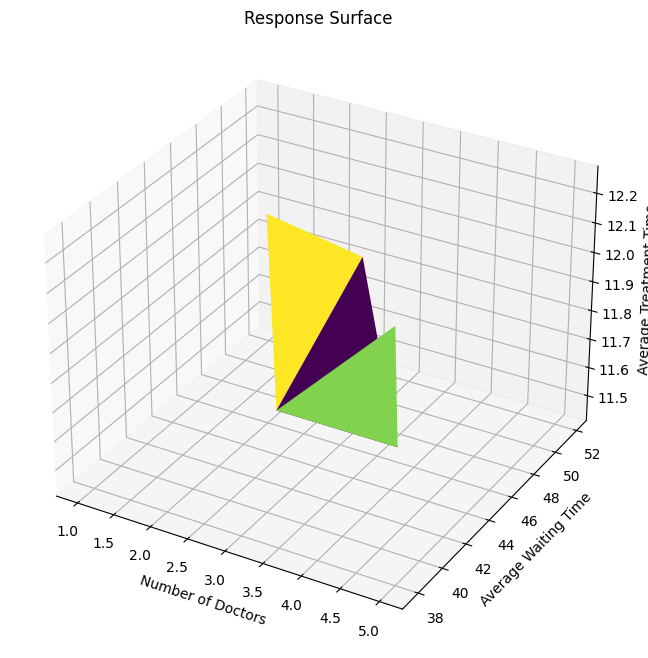

In [102]:
# Perform response surface analysis
def perform_response_surface_analysis():
    # Generate parameter combinations
    parameter_combinations = generate_parameter_combinations()

    # Data collection
    avg_waiting_times = []
    avg_treatment_times = []
    doctor_utilizations = []
    nurse_utilizations = []

    # Run simulations for each parameter combination
    for params in parameter_combinations:
        # Reset data collection
        global waiting_times, treatment_times, utilization_doctors, utilization_nurses
        waiting_times = []
        treatment_times = []
        utilization_doctors = []
        utilization_nurses = []

        # Set up simulation
        env = simpy.Environment()

        # Run simulation
        avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization = run_simulation(env, *params)

        # Collect data
        avg_waiting_times.append(avg_waiting_time)
        avg_treatment_times.append(avg_treatment_time)
        doctor_utilizations.append(doctor_utilization)
        nurse_utilizations.append(nurse_utilization)

    # Plot 3D surface
    x_values = [p[0] for p in parameter_combinations]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(x_values, avg_waiting_times, avg_treatment_times, cmap='viridis', edgecolor='none')

    ax.set_xlabel('Number of Doctors')
    ax.set_ylabel('Average Waiting Time')
    ax.set_zlabel('Average Treatment Time')
    ax.set_title('Response Surface')

    plt.show()

# Run the simulation
perform_response_surface_analysis()

Patient 1 checked-in at 6.84169235425491
Patient 1 triaged at 16.262524926746906
Patient 1 sees a doctor at 16.262524926746906
Patient 2 checked-in at 17.034276114950565
Patient 3 checked-in at 21.08386566983094
Patient 2 triaged at 22.49590283827987
Patient 2 sees a doctor at 22.49590283827987
Patient 3 triaged at 27.60467377016714
Additional doctor summoned at 28. Total doctors: 3
Patient 1 treated by doctor at 31.262524926746906
Patient 3 sees a doctor at 31.262524926746906
Patient 2 treated by doctor at 37.495902838279875
Patient 4 checked-in at 41.12546084653974
Patient 3 treated by doctor at 46.262524926746906
Doctor dismissed at 47. Total doctors: 2
Patient 4 triaged at 47.37688644852785
Patient 4 sees a nurse at 47.37688644852785
Patient 5 checked-in at 56.42725385236244
Patient 4 treated by nurse at 57.37688644852785
Patient 5 triaged at 60.36342489856896
Patient 5 sees a doctor at 60.36342489856896
Patient 6 checked-in at 60.97113850104698
Patient 6 triaged at 65.826207628611

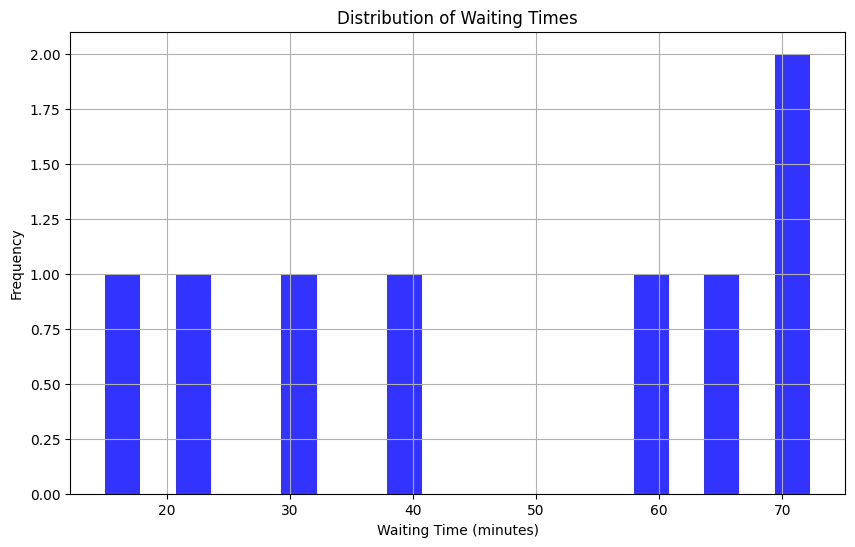

In [104]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
results = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global results

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")
    arrival_time = env.now

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")
    token_time = env.now

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)

    # Record the results
    result = {
        'Patient ID': patient_id,
        'Service': 'Doctor' if critical else 'Nurse',
        'Arrival Time': arrival_time,
        'Token Time': token_time,
        'Service Start Time': env.now - treatment_time,
        'Service Stop Time': env.now,
        'Token Time (Secs)': token_time * 60,
        'Service Time (Mins)': treatment_time,
        'Wait Time (Mins)': waiting_time
    }
    results.append(result)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Create a DataFrame from the collected results
df = pd.DataFrame(results, columns=['Patient ID', 'Service', 'Arrival Time', 'Token Time',
                                    'Service Start Time', 'Service Stop Time', 'Token Time (Secs)',
                                    'Service Time (Mins)', 'Wait Time (Mins)'])

# Performance metric calculation
avg_waiting_time = df['Wait Time (Mins)'].mean()
avg_treatment_time = df['Service Time (Mins)'].mean()
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)


# Print performance metrics
print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(df['Wait Time (Mins)'], bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()


In [105]:
# Display the DataFrame
print(df)

   Patient ID Service  Arrival Time  Token Time  Service Start Time  \
0           1  Doctor      6.841692   16.262525           16.262525   
1           2  Doctor     17.034276   22.495903           22.495903   
2           3  Doctor     21.083866   27.604674           31.262525   
3           4   Nurse     41.125461   47.376886           47.376886   
4           5  Doctor     56.427254   60.363425           60.363425   
5           6   Nurse     60.971139   65.826208           65.826208   
6           7   Nurse     68.155020   75.846126           75.846126   
7           8   Nurse     72.986266   81.868923           81.868923   

   Service Stop Time  Token Time (Secs)  Service Time (Mins)  Wait Time (Mins)  
0          31.262525         975.751496                   15         15.000000  
1          37.495903        1349.754170                   15         21.729659  
2          46.262525        1656.280426                   15         30.797593  
3          57.376886        2842.613